### Homework Scienta Lab

In [18]:
import pandas as pd
import numpy as np
import os, re
from pathlib import Path
from collections import Counter
from tqdm.auto import tqdm

from sklearn.model_selection import RepeatedStratifiedKFold,RepeatedStratifiedKFold, GridSearchCV, StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from stabl.stabl import Stabl
from stabl.multi_omic_pipelines import multi_omic_stabl_cv_noe

import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

from time import time
from joblib import Parallel, delayed
from collections import Counter

In [28]:
%matplotlib inline

In [33]:
def load_tsv(path):
    df = pd.read_csv(path, sep="\t")
    if "Unnamed: 0" in df.columns:
        df.rename(columns={"Unnamed: 0": "SampleID"}, inplace=True)
    return df

healthy_train = load_tsv("data/healthy_train_data.tsv")
healthy_test  = load_tsv("data/healthy_test_data.tsv")
ra_train      = load_tsv("data/ra_train_data.tsv")
ra_test       = load_tsv("data/ra_test_data.tsv")
sle_train     = load_tsv("data/sle_train_data.tsv")
sle_test      = load_tsv("data/sle_test_data.tsv")

print("\nDataset shapes:")
for name, df in zip(
    ["Healthy train","Healthy test","RA train","RA test","SLE train","SLE test"],
    [healthy_train, healthy_test, ra_train, ra_test, sle_train, sle_test]
):
    print(f"{name:<15} → {df.shape}")



Dataset shapes:
Healthy train   → (302, 24404)
Healthy test    → (100, 24404)
RA train        → (1587, 37692)
RA test         → (330, 37692)
SLE train       → (1332, 37692)
SLE test        → (465, 37692)


Because the three cohorts (Healthy, RA, SLE) were profiled with slightly different gene sets, I restricted my analysis to the intersection of genes shared across all datasets to ensure a consistent feature space and avoid cohort-specific artifacts.

With more time, I would have explored alternative strategies such as union-based feature sets combined with imputation and batch-correction techniques.

In [5]:
common_genes = (
    set(healthy_train.columns[1:])
    & set(ra_train.columns[1:])
    & set(sle_train.columns[1:])
)

common_genes = sorted(list(common_genes))

print(f"Common genes across train sets: {len(common_genes)}")

def keep_common(df):
    return df[["SampleID"] + common_genes]


healthy_train = keep_common(healthy_train)
healthy_test  = keep_common(healthy_test)
ra_train      = keep_common(ra_train)
ra_test       = keep_common(ra_test)
sle_train     = keep_common(sle_train)
sle_test      = keep_common(sle_test)


Common genes across train sets: 24403


I identified and used patient-level group identifiers to ensure that samples from the same individual or cohort were kept within the same fold during cross-validation, which is essential to prevent data leakage and obtain a realistic estimate of model performance.

In [6]:
def extract_group_id(s):
    if isinstance(s, str) and s.startswith("GSE"):
        return s.split("_")[0]
    return s

healthy_train["GroupID"] = healthy_train["SampleID"]
ra_train["GroupID"]      = ra_train["SampleID"].apply(extract_group_id)
sle_train["GroupID"]     = sle_train["SampleID"].apply(extract_group_id)


In [7]:
train = pd.concat([healthy_train, ra_train, sle_train], ignore_index=True)
train["Label"] = (
    ["Healthy"] * len(healthy_train)
    + ["RA"] * len(ra_train)
    + ["SLE"] * len(sle_train)
)

label_map = {"Healthy": 0, "RA": 1, "SLE": 2}
train["Label"] = train["Label"].map(label_map)

X = train.drop(columns=["SampleID", "GroupID", "Label"])
y = train["Label"]
groups = train["GroupID"]

print("Train shape:", X.shape)

Train shape: (3221, 24403)


I noticed that there were no missing values in the three datasets, but I kept the imputation step as a safeguard. I also removed features with zero variance, as such genes cannot contribute any signal to the model and only add noise to the analysis.

In [8]:
X = X.fillna(X.mean())

var = VarianceThreshold(0.0)
X = pd.DataFrame(var.fit_transform(X), columns=X.columns[var.get_support()])

print(f"Remaining features after variance filter: {X.shape[1]}")

Remaining features after variance filter: 23553


I also computed the correlation matrix (and saved it to avoid recomputing it every time) to see how many highly correlated genes I could remove. 
Since we started with more than 23,000 features and I didn’t have unlimited time, reducing the feature space was important to make the models (especially STABL) run faster and more smoothly. 
I ended up using a 0.7 correlation threshold, which brought the feature space down to around 8,000 genes.

In [9]:
def compute_or_load_corr_matrix(X, cache_path="corr_matrix.npy", method="pearson", verbose=True):
    if os.path.exists(cache_path):
        if verbose: print(f"📂 Loading correlation matrix from cache: {cache_path}")
        arr = np.load(cache_path)
        return pd.DataFrame(arr, index=X.columns, columns=X.columns)

    if verbose:
        print("⚙️ Computing correlation matrix (may be slow)...")

    corr = X.corr(method=method).abs()
    np.save(cache_path, corr.values)
    
    if verbose:
        print("✓ Correlation matrix computed and cached.")
    return corr


def remove_correlated_features(X, corr=None, threshold=0.90, cache_path="corr_matrix.npy"):
    if corr is None:
        corr = compute_or_load_corr_matrix(X, cache_path)

    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]

    print(f"→ Removing {len(to_drop)} highly correlated genes (thr={threshold})")
    return X.drop(columns=to_drop)


# apply correlation filtering
corr_matrix = compute_or_load_corr_matrix(X, cache_path="corr_matrix.npy")
X = remove_correlated_features(X, corr=corr_matrix, threshold=0.70)

print(f"✓ Remaining features after correlation filtering: {X.shape[1]}")

📂 Loading correlation matrix from cache: corr_matrix.npy
→ Removing 14847 highly correlated genes (thr=0.7)
✓ Remaining features after correlation filtering: 8706


### Baseline before feature selection

Since I haven’t worked much with multiclass medical prediction before, I looked into which metrics made the most sense here. I used **accuracy, macro-F1, macro ROC AUC and macro PR AUC**, because they weigh all three classes equally and avoid favouring the most represented one. 

I also treated the problem in a one-vs-rest setup for feature selection, which is a common and simple way to understand class-specific signals, but there are other multiclass approaches I didn’t have time to explore (like direct multiclass feature selection, or one-vs-one strategies). With more time, I could have experimented with those alternatives to see how much they change the results.

Here is a first baseline of models trained on the "whole data" to have some metrics to compare after a feature selection.

In [13]:
import time

models = {
    "Logistic Regression": LogisticRegression(
        solver="lbfgs",
        multi_class="multinomial",
        max_iter=300,
        n_jobs=-1
    ),  # baseline linear model
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ),  # tree-based ensemble
    "XGBoost": XGBClassifier(
        n_estimators=200,
        n_jobs=-1
    )  # gradient-boosted trees
}

gss = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=42)  # grouped stratified CV
groups = train["GroupID"]  # avoid leakage across samples from same subject

def evaluate_split(model, X, y, groups, train_idx, val_idx, fold):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]  # split features
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]  # split labels
    pipe = make_pipeline(StandardScaler(), model)  # scaling + model
    t0 = time.time(); pipe.fit(X_tr, y_tr); t_fit = time.time() - t0  # train and measure time
    preds = pipe.predict(X_val)  # class predictions
    probas = pipe.predict_proba(X_val)  # probability predictions

    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds, average="macro") 
    y_bin = label_binarize(y_val, classes=np.unique(y))  # one-vs-all format
    roc = roc_auc_score(y_bin, probas, average="macro", multi_class="ovr") 
    pr = average_precision_score(y_bin, probas, average="macro")

    print(f"  ↳ Fold {fold+1:02d}: fit={t_fit:.1f}s | Acc={acc:.3f}, F1={f1:.3f}, ROC={roc:.3f}, PR={pr:.3f}")
    return acc, f1, roc, pr, t_fit

results = {}
for name, model in models.items():
    print(f"\nModel: {name}")
    splits = list(gss.split(X, y, groups))

    metrics = Parallel(n_jobs=1)(
        delayed(evaluate_split)(model, X, y, groups, tr, val, i)
        for i, (tr, val) in enumerate(splits)
    )

    accs, f1s, rocs, prs, tfits = map(np.array, zip(*metrics))

    # averaged metrics across folds
    results[name] = {
        "Accuracy": accs.mean(),
        "F1_macro": f1s.mean(),
        "ROC_AUC_macro": rocs.mean(),
        "PR_AUC_macro": prs.mean(),
        "fit_time_avg": tfits.mean()
    }

print("\nRésultats moyens sur GroupShuffleSplit :")
for name, metrics in results.items():
    print(f"\n{name}:")
    for k, v in metrics.items():
        print(f"{k:<18}: {v:.3f}")


Model: Logistic Regression


/Users/noeamar/Documents/M2DS/Stage M2DS/Scienta Lab/.venv_scienta_lab/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  ↳ Fold 01: fit=17.1s | Acc=0.605, F1=0.693, ROC=0.869, PR=0.802


/Users/noeamar/Documents/M2DS/Stage M2DS/Scienta Lab/.venv_scienta_lab/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  ↳ Fold 02: fit=12.8s | Acc=0.453, F1=0.602, ROC=0.940, PR=0.911


/Users/noeamar/Documents/M2DS/Stage M2DS/Scienta Lab/.venv_scienta_lab/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  ↳ Fold 03: fit=12.2s | Acc=0.604, F1=0.717, ROC=0.756, PR=0.736


/Users/noeamar/Documents/M2DS/Stage M2DS/Scienta Lab/.venv_scienta_lab/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  ↳ Fold 04: fit=14.1s | Acc=0.804, F1=0.831, ROC=0.929, PR=0.916


/Users/noeamar/Documents/M2DS/Stage M2DS/Scienta Lab/.venv_scienta_lab/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  ↳ Fold 05: fit=13.6s | Acc=0.599, F1=0.696, ROC=0.701, PR=0.668


/Users/noeamar/Documents/M2DS/Stage M2DS/Scienta Lab/.venv_scienta_lab/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  ↳ Fold 06: fit=14.6s | Acc=0.710, F1=0.762, ROC=0.843, PR=0.765


/Users/noeamar/Documents/M2DS/Stage M2DS/Scienta Lab/.venv_scienta_lab/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  ↳ Fold 07: fit=13.2s | Acc=0.643, F1=0.657, ROC=0.957, PR=0.914


/Users/noeamar/Documents/M2DS/Stage M2DS/Scienta Lab/.venv_scienta_lab/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  ↳ Fold 08: fit=14.3s | Acc=0.520, F1=0.645, ROC=0.722, PR=0.663


/Users/noeamar/Documents/M2DS/Stage M2DS/Scienta Lab/.venv_scienta_lab/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  ↳ Fold 09: fit=13.5s | Acc=0.648, F1=0.739, ROC=0.758, PR=0.722


/Users/noeamar/Documents/M2DS/Stage M2DS/Scienta Lab/.venv_scienta_lab/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  ↳ Fold 10: fit=14.1s | Acc=0.333, F1=0.508, ROC=0.560, PR=0.579

Model: Random Forest
  ↳ Fold 01: fit=1.7s | Acc=0.546, F1=0.647, ROC=0.735, PR=0.673
  ↳ Fold 02: fit=1.6s | Acc=0.818, F1=0.840, ROC=0.964, PR=0.939
  ↳ Fold 03: fit=1.4s | Acc=0.455, F1=0.600, ROC=0.645, PR=0.631
  ↳ Fold 04: fit=1.6s | Acc=0.650, F1=0.712, ROC=0.813, PR=0.792
  ↳ Fold 05: fit=1.6s | Acc=0.496, F1=0.621, ROC=0.685, PR=0.682
  ↳ Fold 06: fit=1.7s | Acc=0.665, F1=0.721, ROC=0.764, PR=0.656
  ↳ Fold 07: fit=1.7s | Acc=0.584, F1=0.626, ROC=0.978, PR=0.838
  ↳ Fold 08: fit=1.8s | Acc=0.480, F1=0.615, ROC=0.733, PR=0.672
  ↳ Fold 09: fit=1.6s | Acc=0.434, F1=0.593, ROC=0.636, PR=0.648
  ↳ Fold 10: fit=1.7s | Acc=0.296, F1=0.481, ROC=0.585, PR=0.601

Model: XGBoost
  ↳ Fold 01: fit=30.7s | Acc=0.532, F1=0.636, ROC=0.814, PR=0.757
  ↳ Fold 02: fit=31.0s | Acc=0.665, F1=0.733, ROC=0.880, PR=0.821
  ↳ Fold 03: fit=24.2s | Acc=0.450, F1=0.579, ROC=0.712, PR=0.713
  ↳ Fold 04: fit=36.9s | Acc=0.527, F1=0.650, RO

In medical applications, model interpretability really matters, so it’s important to reduce the number of genes and focus on the most meaningful ones. 

To better understand which genes really drive the multiclass prediction (Healthy vs RA vs SLE), I first built a simple baseline based on standard models. I trained a multinomial Logistic Regression, a Random Forest and an XGBoost model on the full dataset, ranked genes by their coefficients/feature importance, and then evaluated models using only the top-K genes (with K ranging from 10 to 200).

In [ ]:
# Train models to compute feature importance
healthy_test["Label"] = 0
ra_test["Label"] = 1
sle_test["Label"] = 2

test = pd.concat([healthy_test, ra_test, sle_test], ignore_index=True)

X_test = test.drop(columns=["SampleID", "Label"])
y_test = test["Label"]

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

logreg = LogisticRegression(
    solver="lbfgs",
    multi_class="multinomial",
    max_iter=200,
    n_jobs=-1
)

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

xgb = XGBClassifier(
    n_estimators=200,
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    n_jobs=-1
)

print("Training models for baseline feature importance...")
logreg.fit(X, y)
rf.fit(X, y)
xgb.fit(X, y)


# feature importances

# LogisticRegression
imp_logreg = np.sum(np.abs(logreg.coef_), axis=0)

# RandomForest
imp_rf = rf.feature_importances_

# XGBoost
imp_xgb = xgb.feature_importances_

importance_dict = {
    "LogReg": imp_logreg,
    "RandomForest": imp_rf,
    "XGBoost": imp_xgb
}


# top-K features


def evaluate_topK(importance, model_name, K_values):

    perf_acc, perf_f1 = [], []

    # Ranking from most → least important
    order = np.argsort(importance)[::-1]

    for K in K_values:
        top_features = X.columns[order[:K]]
        # scale + logistic regression final model
        pipe = make_pipeline(
            StandardScaler(),
            LogisticRegression(
                solver="lbfgs",
                multi_class="multinomial",
                max_iter=500,
                n_jobs=-1
            )
        )
        pipe.fit(X[top_features], y)
        preds = pipe.predict(X_test[top_features])
        probas = pipe.predict_proba(X_test[top_features])

        f1 = f1_score(y_test, preds, average="macro")
        acc = accuracy_score(y_test, preds)

        perf_acc.append(acc)
        perf_f1.append(f1)

    return perf_acc, perf_f1


K_values = [10, 20, 40, 80, 120, 160, 200]

results_baseline = {}

for model_name, importance in importance_dict.items():
    accs, f1s = evaluate_topK(importance, model_name, K_values)
    results_baseline[model_name] = {"acc": accs, "f1": f1s}
    print(results_baseline)

X_test shape: (895, 24403)
y_test shape: (895,)
Training models for baseline feature importance...


/Users/noeamar/Documents/M2DS/Stage M2DS/Scienta Lab/.venv_scienta_lab/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'LogReg': {'acc': [0.7955307262569833, 0.5910614525139665, 0.5553072625698324, 0.7083798882681565, 0.735195530726257, 0.693854748603352, 0.7854748603351955], 'f1': [0.806346252967967, 0.6537655045174027, 0.6548799884273381, 0.7773874388743329, 0.7995227983818426, 0.765711519886303, 0.8370268179897868]}}


/Users/noeamar/Documents/M2DS/Stage M2DS/Scienta Lab/.venv_scienta_lab/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/noeamar/Documents/M2DS/Stage M2DS/Scienta Lab/.venv_scienta_lab/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alter

{'LogReg': {'acc': [0.7955307262569833, 0.5910614525139665, 0.5553072625698324, 0.7083798882681565, 0.735195530726257, 0.693854748603352, 0.7854748603351955], 'f1': [0.806346252967967, 0.6537655045174027, 0.6548799884273381, 0.7773874388743329, 0.7995227983818426, 0.765711519886303, 0.8370268179897868]}, 'RandomForest': {'acc': [0.6357541899441341, 0.49273743016759775, 0.6625698324022347, 0.6804469273743017, 0.6044692737430167, 0.6156424581005586, 0.6424581005586593], 'f1': [0.7098786991389385, 0.5732961638860515, 0.7345372886372897, 0.7511916799075545, 0.6849603051999517, 0.6938597316067326, 0.7218869706669465]}}
{'LogReg': {'acc': [0.7955307262569833, 0.5910614525139665, 0.5553072625698324, 0.7083798882681565, 0.735195530726257, 0.693854748603352, 0.7854748603351955], 'f1': [0.806346252967967, 0.6537655045174027, 0.6548799884273381, 0.7773874388743329, 0.7995227983818426, 0.765711519886303, 0.8370268179897868]}, 'RandomForest': {'acc': [0.6357541899441341, 0.49273743016759775, 0.6625

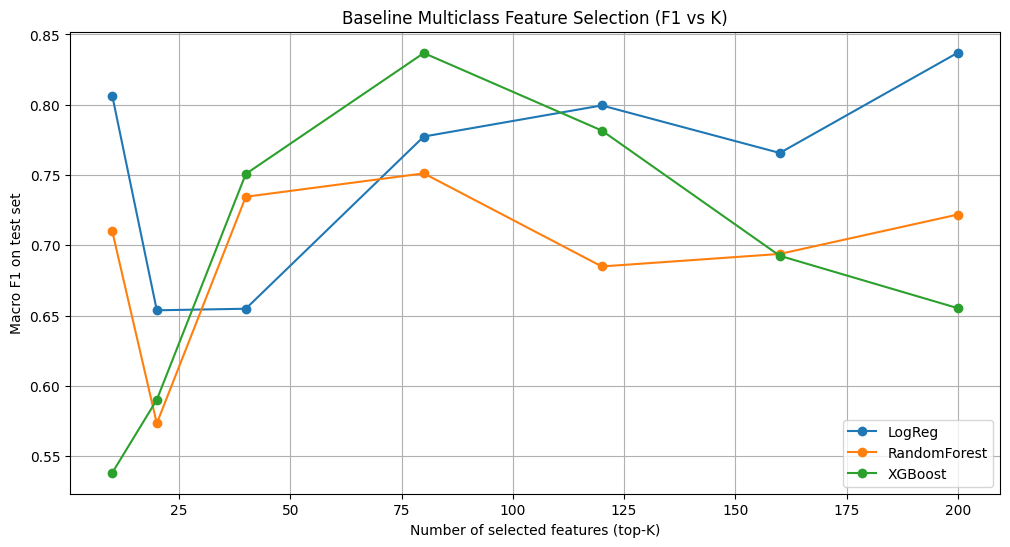

In [30]:
plt.figure(figsize=(12,6))
for model_name, res in results_baseline.items():
    plt.plot(K_values, res["f1"], marker="o", label=f"{model_name}")

plt.xlabel("Number of selected features (top-K)")
plt.ylabel("Macro F1 on test set")
plt.title("Baseline Multiclass Feature Selection (F1 vs K)")
plt.legend()
plt.grid(True)
plt.show()

Interestingly, all three models showed the same trend:
using about 60–120 genes gives the best performance, while using too few or too many hurts the model (except logistic regression). This makes sense, too few genes throw away information, but too many re-introduce noise that harms generalization.

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# folder for saving plots
pdp_dir = "pdp_plots_multiclass"
os.makedirs(pdp_dir, exist_ok=True)

# top 6 genes by importance
top_genes = feat_imp["gene"].head(6).tolist()
print("Top genes for PDP:", top_genes)

# matching indices in X
feature_indices = [union_feats.index(g) for g in top_genes]

class_names = ["Healthy", "RA", "SLE"]

# For each gene, produce 1 PDP per class
for gene, idx in zip(top_genes, feature_indices):
    for class_id, class_label in enumerate(class_names):

        fig = plt.figure(figsize=(6, 4))
        PartialDependenceDisplay.from_estimator(
            final_model,
            X_train_scaled,
            features=[idx],
            feature_names=union_feats,
            target=class_id,            
            grid_resolution=60,
            ax=plt.gca()
        )

        plt.title(f"PDP for {gene} – class={class_label}")
        plt.tight_layout()

        save_path = os.path.join(pdp_dir, f"PDP_{gene}_class_{class_label}.png")
        plt.savefig(save_path, dpi=300)
        plt.close()

        print(f"Saved {save_path}")

Top genes for PDP: ['ARL2BP', 'PRR12', 'PNPLA2', 'RASA4DP', 'CTDNEP1', 'MLLT6']
Saved pdp_plots_multiclass/PDP_ARL2BP_class_Healthy.png
Saved pdp_plots_multiclass/PDP_ARL2BP_class_RA.png
Saved pdp_plots_multiclass/PDP_ARL2BP_class_SLE.png
Saved pdp_plots_multiclass/PDP_PRR12_class_Healthy.png
Saved pdp_plots_multiclass/PDP_PRR12_class_RA.png
Saved pdp_plots_multiclass/PDP_PRR12_class_SLE.png
Saved pdp_plots_multiclass/PDP_PNPLA2_class_Healthy.png
Saved pdp_plots_multiclass/PDP_PNPLA2_class_RA.png
Saved pdp_plots_multiclass/PDP_PNPLA2_class_SLE.png
Saved pdp_plots_multiclass/PDP_RASA4DP_class_Healthy.png
Saved pdp_plots_multiclass/PDP_RASA4DP_class_RA.png
Saved pdp_plots_multiclass/PDP_RASA4DP_class_SLE.png
Saved pdp_plots_multiclass/PDP_CTDNEP1_class_Healthy.png
Saved pdp_plots_multiclass/PDP_CTDNEP1_class_RA.png
Saved pdp_plots_multiclass/PDP_CTDNEP1_class_SLE.png
Saved pdp_plots_multiclass/PDP_MLLT6_class_Healthy.png
Saved pdp_plots_multiclass/PDP_MLLT6_class_RA.png
Saved pdp_plots_m

Across the models, several genes consistently appear among the most informative. 

MLLT6, PRR12 adn CTDNEP1 appear repeatedly as well and seem to capture more subtle patterns that help differentiate RA from SLE.

RASA4DP seems to be informative regarding healthy vs disease in general.

Even though I’m not aiming for an in-depth biological interpretation, these patterns match what we see in the data:
some genes mostly distinguish healthy vs sick, while others help split RA vs SLE, which is the harder boundary in the dataset.

Overall, this top-K baseline gives a simple—but useful—multiclass feature selection approach to compare with more sophisticated methods like STABL. It also helps answer the second question of the assignment:

Based on the predictive model, which genes seem to drive the diseases?
From all the analyses, the most influential ones include:
PNPLA2, ARL2BP, ARID5A, SAMD1, PCBP1, BRCA1, among others.
These genes strongly shape the model’s predictions and reflect the main gene-expression patterns distinguishing healthy subjects from RA/SLE patients and, to a lesser extent, RA from SLE.

### STABL (potential sparser feature selection technique)

After exploring the simple top-K baselines, I switched to STABL for a more principled feature-selection step. STABL is the stability-based method I worked on during my internship at Stanford, and although it was originally designed for linear models, part of my work there involved extending it to tree-based approaches like Random Forests and XGBoost. That’s exactly what I rely on here.

STABL fits well with this type of dataset because instead of chasing one-off signals, it focuses on selecting the genes that remain consistently important across many bootstraps. With thousands of genes at the start, having a stability-driven selection helps avoid keeping features that look useful in a single split but disappear everywhere else.

The main limitation is that the current STABL pipeline is built for binary classification. Adapting it properly to a full multiclass setup (RA vs SLE vs healthy) would have required rewriting part of the framework, which wasn’t realistic given the time. So I used the classic workaround: running STABL in a one-vs-rest manner, once per class. It’s not perfect because each model sees a slightly different version of the problem, but it allowed me to extract class-specific stable gene sets without changing the whole pipeline.

I also couldn’t run every STABL variant (Lasso, Adaptive Lasso, ElasticNet, XGB…) because they take much longer to converge on such a large feature space. STABL-RF was the only one fast enough thanks to Random Forests being naturally parallelizable, which drastically cuts down the total runtime.

In [ ]:
# ============================================================
# 1. Configuration des splits
# ============================================================
outer_cv = StratifiedGroupKFold(n_splits=25, shuffle=True, random_state=42)
inner_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)


# ============================================================
# 2. Définition des modèles de base
# ============================================================
lasso= LogisticRegression(
    penalty="l1",
    solver="saga",
    class_weight="balanced",
    max_iter=100,
)

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=8,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1,
)

xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)

en = LogisticRegression(
    penalty="elasticnet",
    solver="saga",
    class_weight="balanced",
    max_iter=100,
    random_state=42,
)


# ============================================================
# 3. Grilles d’hyperparamètres
# ============================================================
rf_grid = {"max_depth": [5, 7, 9]}
xgb_grid = {"max_depth": [4, 6, 8], "reg_alpha": [0, 0.1, 1]}
en_grid = [{"C": np.logspace(-2, 1, 5), "l1_ratio": [0.5, 0.9]}]

# ============================================================
# 4. GridSearch interne
# ============================================================
lasso_cv = GridSearchCV(lasso, param_grid={"alpha": np.logspace(-2, 2, 5)}, scoring="roc_auc", cv=inner_cv, n_jobs=-1)

rf_cv = GridSearchCV(rf, param_grid=rf_grid, scoring="roc_auc",
                     cv=inner_cv, n_jobs=-1)

xgb_cv = GridSearchCV(xgb, param_grid=xgb_grid, scoring="roc_auc",
                      cv=inner_cv, n_jobs=-1)
en_cv = GridSearchCV(en, param_grid=en_grid, scoring="roc_auc",
                      cv=inner_cv, n_jobs=-1)

# ============================================================
# 5. Configuration des modèles STABL
# ============================================================
base_stabl = Stabl(
    n_bootstraps=30,
    artificial_proportion=0.5,
    artificial_type="random_permutation",
    replace=False,
    fdr_threshold_range=np.arange(0.1, 1, 0.01),
    sample_fraction=0.5,
    random_state=42,
)

stabl_lasso = clone(base_stabl).set_params(
    base_estimator=lasso,
    lambda_grid={"C": np.logspace(-3, 1, 10)},
)

stabl_rf = clone(base_stabl).set_params(
    n_bootstraps=200,
    base_estimator=rf,
    lambda_grid={"max_depth": [5, 7, 9]},
    fdr_threshold_range=np.arange(0.3, 1, 0.01),
)

stabl_xgb = clone(base_stabl).set_params(
    base_estimator=xgb,
    lambda_grid={"max_depth": [4, 6, 8], "reg_alpha": [0, 0.1, 1]},
)

stabl_en = clone(base_stabl).set_params(
    base_estimator=en,
    lambda_grid=[{"C": np.logspace(-2, 1, 5), "l1_ratio": [0.5, 0.9]}],
    verbose=1,
)

# ============================================================
# 6. Dictionnaire des estimateurs STABL
# ============================================================
stabl_models = {
    "stabl_lasso": stabl_lasso,
    "stabl_rf": stabl_rf,
}

estimators = {
    "lasso": lasso_cv,
    "alasso": lasso_cv,
    "rf": rf_cv,
    "xgb": xgb_cv,
    "en": en_cv,
    "stabl_lasso": stabl_lasso,
    "stabl_en": stabl_en,
    "stabl_alasso": stabl_lasso,
    "stabl_rf": stabl_rf,
    "stabl_xgb": stabl_xgb,
}

models = ["STABL RandomForest"]

# ============================================================
# 7. Configuration des données
# ============================================================
data_dict = {"transcriptomic": X}
outer_groups = train["GroupID"]

classes = [0, 1, 2]
class_names = ["Healthy", "RA", "SLE"]

# ============================================================
# 8. Boucle OvR (One-vs-Rest) pour Lasso + RF
# ============================================================
all_selected_features = {m: {} for m in stabl_models.keys()}


for i, cls in enumerate(classes):
    print(f"\n{class_names[i]} vs Rest ===")

    y_binary = (y == cls).astype(int)
    save_path = "results/" + f"stabl_{class_names[i]}_vs_rest"
    multi_omic_stabl_cv_noe(
        data_dict=data_dict,
        y=y_binary,
        outer_splitter=outer_cv,
        estimators=estimators,
        task_type="binary",
        model_chosen="xgboost",
        models=models,
        save_path=save_path,
        importance_method="MDA",
        outer_groups=outer_groups,
        early_fusion=False,
        late_fusion=True,
        )

        # # Load selected features
        # feat_file = save_dir / "Training CV" / f"Selected Features {model_name.upper()}.csv"
        # df = pd.read_csv(feat_file)
        # df["Fold selected features"] = df["Fold selected features"].apply(eval)

        # # union des features sélectionnées dans les folds
        # selected = sorted({f for fold in df["Fold selected features"] for f in fold})
        # all_selected_features[model_name][class_names[i]] = selected

In [ ]:
stabl_files = {
    "Healthy_vs_Rest": "results/stabl_Healthy_vs_rest/Training CV/Selected Features STABL RandomForest.csv",
    "RA_vs_Rest":      "results/stabl_RA_vs_rest/Training CV/Selected Features STABL RandomForest.csv",
    "SLE_vs_Rest":     "results/stabl_SLE_vs_rest/Training CV/Selected Features STABL RandomForest.csv"
}

selected_features_per_class = {}
topK = 30  # choose most frequent genes per class

for dataset_name, path in stabl_files.items():
    print(f"→ Reading: {dataset_name}")
    df = pd.read_csv(path)
    df["Fold selected features"] = df["Fold selected features"].apply(literal_eval)

    all_feats = [f for lst in df["Fold selected features"] for f in lst]
    freq = Counter(all_feats)

    freq_df = (
        pd.DataFrame.from_dict(freq, orient="index", columns=["freq"])
        .sort_values("freq", ascending=False)
        .reset_index()
        .rename(columns={"index": "feature"})
    )

    selected_features_per_class[dataset_name] = freq_df["feature"].head(topK).tolist()
    print(f"  ✓ Loaded {len(freq_df)} unique genes, keeping top {topK}")

→ Reading: Healthy_vs_Rest
  ✓ Loaded 90 unique genes, keeping top 30
→ Reading: RA_vs_Rest
  ✓ Loaded 112 unique genes, keeping top 30
→ Reading: SLE_vs_Rest
  ✓ Loaded 120 unique genes, keeping top 30


In [ ]:
union_feats = sorted(
    set(selected_features_per_class["Healthy_vs_Rest"])
    | set(selected_features_per_class["RA_vs_Rest"])
    | set(selected_features_per_class["SLE_vs_Rest"])
)

print("\nTOTAL UNIQUE GENES SELECTED BY STABL (union):", len(union_feats))



OTAL UNIQUE GENES SELECTED BY STABL (union): 85


In [ ]:
union_feats = [g for g in union_feats if g in X.columns]
print(f"Gènes présents dans X après intersection : {len(union_feats)}")
class_names = ["Healthy", "RA", "SLE"]

# Construction du jeu de test complet (Healthy + RA + SLE)


healthy_test["Label"] = 0
ra_test["Label"] = 1
sle_test["Label"] = 2

test = pd.concat([healthy_test, ra_test, sle_test], ignore_index=True)

# Vérifier que les gènes STABL sont bien dans le test set
missing_in_test = [g for g in union_feats if g not in test.columns]
if len(missing_in_test) > 0:
    print(f"\n{len(missing_in_test)} gènes STABL absents du test set → on les retire.")
    union_feats = [g for g in union_feats if g in test.columns]

print(f"Gènes finaux utilisés pour le modèle : {len(union_feats)}")

X_train_sel = X[union_feats].copy()
X_test_sel  = test[union_feats].copy()
y_test      = test["Label"]

print("\nShapes finales :")
print("  X_train_sel :", X_train_sel.shape)
print("  X_test_sel  :", X_test_sel.shape)


# Standardisation + entraînement du modèle final (XGBoost multiclass)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled  = scaler.transform(X_test_sel)

final_model = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    objective="multi:softprob",
    eval_metric="mlogloss",
    num_class=3,
    n_jobs=-1,
    random_state=42,
)

# final_model = LogisticRegression(
#     solver="lbfgs",
#     multi_class="multinomial",
#     max_iter=500,
#     n_jobs=-1
# )

print(" Entraînement du modèle final XGBoost (multiclass)")
final_model.fit(X_train_scaled, y)

y_pred  = final_model.predict(X_test_scaled)
y_proba = final_model.predict_proba(X_test_scaled)

# ============================================================
# 12. Évaluation sur le jeu de test
# ============================================================

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred, average="macro")

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
roc = roc_auc_score(y_test_bin, y_proba, average="macro", multi_class="ovr")
pr  = average_precision_score(y_test_bin, y_proba, average="macro")

print("\n PERFORMANCE FINALE SUR TEST SET ")
print(f"Accuracy         : {acc:.3f}")
print(f"F1_macro         : {f1:.3f}")
print(f"ROC AUC (macro)  : {roc:.3f}")
print(f"PR AUC (macro)   : {pr:.3f}")

print("\n Classification report (Healthy=0, RA=1, SLE=2)")
print(classification_report(y_test, y_pred, digits=3))

print("\nMatrice de confusion")
print(confusion_matrix(y_test, y_pred))


# Interprétation : gènes drivers selon XGBoost + STABL

importances = final_model.feature_importances_
feat_imp = (
    pd.DataFrame({"gene": union_feats, "importance": importances})
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

print("\n=== Top 20 gènes par importance XGBoost ===")
print(feat_imp.head(20))

Gènes présents dans X après intersection : 85
Gènes finaux utilisés pour le modèle : 85

Shapes finales :
  X_train_sel : (3221, 85)
  X_test_sel  : (895, 85)

 Entraînement du modèle final XGBoost (multiclass)

=== 📊 PERFORMANCE FINALE SUR TEST SET ===
Accuracy         : 0.514
F1_macro         : 0.575
ROC AUC (macro)  : 0.791
PR AUC (macro)   : 0.729

=== Classification report (Healthy=0, RA=1, SLE=2) ===
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       100
           1      0.431     1.000     0.603       330
           2      1.000     0.065     0.121       465

    accuracy                          0.514       895
   macro avg      0.810     0.688     0.575       895
weighted avg      0.790     0.514     0.397       895


=== Matrice de confusion ===
[[100   0   0]
 [  0 330   0]
 [  0 435  30]]

=== Top 20 gènes par importance XGBoost ===
             gene  importance
0          ARL2BP    0.128597
1           PRR12    0.09225

Using the 85 common genes across the three cohorts, the final XGBoost multiclass model reaches 51% accuracy and a macro-F1 of 0.575.
The ROC-AUC macro (0.79) and PR-AUC macro (0.73) show that the model does capture meaningful structure, but performance varies a lot across classes:
	•	Healthy (class 0) is perfectly predicted (100/100).
	•	RA (class 1) is always detected as RA (recall = 1.00), but with moderate precision.
	•	SLE (class 2) is clearly the hardest: most SLE samples are misclassified as RA.

This is visible in the confusion matrix, where 435 out of 465 SLE patients are predicted as RA.
So the model strongly separates healthy vs autoimmune disease, but struggles to disentangle RA from SLE with the 85 intersected genes.

Interestingly, the top features identified by XGBoost line up well with those selected by STABL, which is reassuring and suggests that both methods consistently highlight the same high-signal genes.
The main limitation on the STABL side is that I had to use it in a one-vs-rest setup (because the current implementation is binary), which probably limits its ability to isolate clean, multiclass-specific gene signatures—especially for RA vs SLE.

A further step would have been to try and adapt the STABL pipeline for multi class problems.